In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchaudio
from tqdm.auto import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import lib
import librosa
from typing import List, Tuple

C:\Users\sanat\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [11]:
class MusicDataset(Dataset):
    "Dataset for loading/preprocessing of audio data"

    def __init__(self,
                 audio_dir: os.path or str,
                 transformation: torchaudio.transforms,
                 sample_rate: int,
                 num_samples: int,
                 device: torch.device):
        """
        Initializes the constructor
        Parameters: audio_dir: path to the audio directory
        transformation: transformation applied to the audio
        sample_rate: sampling rate.
        """

        super(MusicDataset, self).__init__()
        self.audio_dir = audio_dir
        self.transformation = transformation.to(device)
        self.target_sample_rate = sample_rate
        self.num_samples = num_samples
        self.device = device

    def __len__(self) -> int:
        """
        Return length of dataset (audio samples)
        """
        return len(os.listdir(self.audio_dir))

    def __getitem__(self, index) -> torch.Tensor:
        audio_sample_path = os.path.join(
            self.audio_dir, os.listdir(self.audio_dir)[index])
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)

        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)

        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        signal = self.transformation(signal)
        return signal

    def _cut_if_necessary(self, signal):
        """
        Trims the part of signal if signal length > num_samples
        """
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        """
        Pads the signal if signal length < num_samples
        """
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            singal = F.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        """
        Resamples the audio if needed sample rate and the audio sample rate are not same
        """
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(
                sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal


Audio_dir = os.path.join(os.getcwd(), "audio_files")
SAMPLE_RATE = 22050
NUM_SAMPLES = 163180
device = "cuda" if torch.cuda.is_available() else "cpu"

mel_spectogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

music_dataset = MusicDataset(audio_dir=Audio_dir,
                             transformation=mel_spectogram,
                             sample_rate=SAMPLE_RATE,
                             num_samples=NUM_SAMPLES,
                             device=device)

music_dataset[0].shape, music_dataset[1].shape

(torch.Size([1, 64, 319]), torch.Size([1, 64, 319]))

In [207]:
characters = "abcd efghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_-,.?;':!@#$%^&*()"
char_to_idx = {k: v for v, k in enumerate(characters)}
idx_to_char = {k: v for k, v in enumerate(characters)}

PADDING_TOKEN = '?'
MAX_SEQ_LEN = 1276
N_EMBD = 256
vocab_size = len(characters)

In [208]:
def char_to_tensor(char,
                   vocab_to_index,
                   vocab_size):
    # print(char)
    char_tensor = torch.zeros((vocab_size))
    char_tensor[vocab_to_index[char]] = 1
    return char_tensor


def sentence_to_tensor(sen,
                       vocab_to_index,
                       vocab_size,
                       max_seq_len):
    # print(sen)
    padding_tensor = char_to_tensor(char=PADDING_TOKEN,
                                    vocab_to_index=vocab_to_index,
                                    vocab_size=vocab_size)
    sen_tensor = torch.stack([padding_tensor] * max_seq_len)
    sen = sen[:max_seq_len-1]
    # print(sen_tensor.shape)
    for i, char in enumerate(sen):
        char_tensor = char_to_tensor(char=char,
                                     vocab_to_index=vocab_to_index,
                                     vocab_size=vocab_size)
        sen_tensor[i] = char_tensor
    return sen_tensor


def sentences_to_tensor(sentences,
                        vocab_to_index,
                        vocab_size,
                        max_seq_len):
    batch_size = len(sentences)
    sens_tensor = torch.zeros(batch_size, max_seq_len, vocab_size)
    for i, sen in enumerate(sentences):
        sen_tensor = sentence_to_tensor(sen=sen,
                                        vocab_to_index=vocab_to_index,
                                        vocab_size=vocab_size,
                                        max_seq_len=max_seq_len)
        sens_tensor[i] = sen_tensor
    return sens_tensor


# sentence_to_tensor(sen="my",
#                    vocab_to_index=char_to_idx,
#                    vocab_size=vocab_size,
#                    max_seq_len=MAX_SEQ_LEN).shape

In [209]:
class TextDataset(Dataset):
    def __init__(self, text_dir, device):
        super(TextDataset, self).__init__()

        self.text_dir = text_dir
        self.device = device

    def __len__(self):
        return len(os.listdir(self.text_dir))

    def __getitem__(self, index):
        text_file = os.path.join(
            self.text_dir, os.listdir(self.text_dir)[index])
        with open(text_file, 'r') as f:
            text = f.read().replace('\n', '').replace('â', "").replace(
                "€", "").replace("™", "").replace("…", "")

        return sentence_to_tensor(sen=text,
                                  vocab_to_index=char_to_idx,
                                  vocab_size=vocab_size,
                                  max_seq_len=MAX_SEQ_LEN)


Text_dir = os.path.join(os.getcwd(), "text_files")
text_dataset = TextDataset(text_dir=Text_dir,
                           device=device)
print(f"hi {text_dataset[5].shape}")

hi torch.Size([1276, 71])


In [210]:
BATCH_SIZE = 2


def create_dataloader(train_data, batch_size):
    train_dataloder = DataLoader(train_data, batch_size=batch_size)
    return train_dataloder


text_dataloader = create_dataloader(train_data=text_dataset,
                                    batch_size=BATCH_SIZE)
audio_dataloader = create_dataloader(train_data=music_dataset,
                                     batch_size=BATCH_SIZE)

## Model 

In [232]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def forward(self,
                input_encodings):

        batch_size, max_seq_len, n_embd = input_encodings.size()
        i = torch.arange(0, n_embd, 2).float()

        denominator = torch.pow(10_000, (i)/n_embd).type(torch.float32)
        position = torch.arange(
            0, max_seq_len, dtype=torch.float32).reshape(max_seq_len, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2).view(max_seq_len, -1)
        return stacked.unsqueeze(0).repeat(batch_size, 1, 1)


class GlobalVarianceNormalization(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(GlobalVarianceNormalization, self).__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        # Calculate the global mean and variance
        global_mean = torch.mean(x)
        global_var = torch.var(x, unbiased=False) + self.eps

        # Normalize the input tensor using the global mean and variance
        x = (x - global_mean) / torch.sqrt(global_var)

        # Apply learnable scale and shift (weight and bias)
        x = x * self.weight + self.bias
        return x


class FFTBlock(nn.Module):
    def __init__(self,
                 n_embd,
                 num_heads,
                 device,
                 mask,
                 kernel_size,
                 stride,
                 padding,
                 max_seq_len):

        super(FFTBlock, self).__init__()

        self.k = nn.Linear(n_embd, n_embd)
        self.q = nn.Linear(n_embd, n_embd)
        self.v = nn.Linear(n_embd, n_embd)

        self.multiheadAttention = nn.MultiheadAttention(embed_dim=n_embd,
                                                        num_heads=num_heads,
                                                        dropout=0.3,
                                                        device=device)

        self.norm = GlobalVarianceNormalization(normalized_shape=n_embd)
        self.mask = mask  # check shape

        # something for same shape
        self.conv1 = nn.Conv1d(in_channels=max_seq_len,
                               out_channels=max_seq_len,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding)

        self.linear = nn.Sequential(
            nn.Linear(n_embd, 2 * n_embd),
            nn.Tanh(),
            nn.Linear(2 * n_embd, n_embd),
            nn.Tanh(),
        )

    def forward(self, x):
        k = self.k(x)
        q = self.q(x)
        v = self.v(x)

        temp = self.multiheadAttention(q, k, v, need_weights=False)
        # print(temp[0].shape)
        temp = temp[0]
        temp = self.norm(x + temp)
        temp = self.linear(temp)
        # print(temp.shape)
        x = temp
        temp = self.conv1(temp)
        temp = self.linear(temp)
        # print(temp.shape)
        temp = self.norm(temp + x)
        # print(f"returning from fft")
        return temp


class Encoder(nn.Module):
    def __init__(self,
                 max_seq_len,
                 n_embd,
                 device,
                 n_heads,
                 mask,
                 kernel_size,
                 padding,
                 stride,
                 vocab_size):

        super(Encoder, self).__init__()
        self.text_encoding = nn.Linear(vocab_size, n_embd)
        self.positional_encodings = PositionalEncoding()
        self.fft = FFTBlock(n_embd=n_embd,
                            num_heads=n_heads,
                            device=device,
                            mask=mask,
                            kernel_size=kernel_size,
                            stride=stride,
                            padding=padding,
                            max_seq_len=max_seq_len)

        self.linear = nn.Sequential(
            nn.Linear(n_embd, n_embd // 2),
            nn.Linear(n_embd // 2, (319 * 64) // max_seq_len)
        )

    def forward(self, text_input):
        text_input = self.text_encoding(text_input)
        # print(f"After text encoding -> {text_input.shape}")
        pos = self.positional_encodings(text_input)
        text_input += pos
        text_input = self.fft(text_input)
        text_input = self.fft(text_input)
        text_input = self.linear(text_input)
        return text_input


def train_one_step(model, loss_fn, optimizer, text_dataloader, audio_dataloader, device):
    model.to(device)
    model.train()

    losses = 0
    for text_input, audio_input in tqdm(zip(text_dataloader, audio_dataloader)):

        text_input, audio_input = text_input.to(device), audio_input.to(device)
        mel_spectogram = model(text_input)

        mel_spectogram = mel_spectogram.reshape(audio_input.shape)
        loss = loss_fn(mel_spectogram, audio_input)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # some stats
        losses += loss.item()

    return losses


def train(model, loss_fn, optimizer, text_dataloader, audio_dataloader, device, epochs):
    losses = []
    for epoch in tqdm(range(epochs)):
        t_losses = train_one_step(model=model,
                                  loss_fn=loss_fn,
                                  optimizer=optimizer,
                                  text_dataloader=text_dataloader,
                                  audio_dataloader=audio_dataloader,
                                  device=device)

        losses.append(t_losses)

    return losses

In [212]:
music_dataset[0].shape, music_dataset[1].shape

(torch.Size([1, 64, 319]), torch.Size([1, 64, 319]))

In [213]:
n_embd = 256
# x = torch.randn((2, 40, n_embd)) # batch, max_len, n_embd
# fft = FFTBlock(n_embd=n_embd,
#                num_heads=2,
#                device=device,
#                mask=None,
#                kernel_size=3,
#                stride=1,
#                padding=1,
#                max_seq_len=40)
# fft(x).shape

x = torch.randn((2, 40, vocab_size)).type(
    torch.float32)  # batch, max_len, n_embd

mo = Encoder(max_seq_len=40,
             n_embd=n_embd,
             device=device,
             n_heads=2,
             mask=None,
             kernel_size=3,
             padding=1,
             stride=1,
             vocab_size=vocab_size)

mo(x).shape, x.shape

(torch.Size([2, 40, 510]), torch.Size([2, 40, 71]))

In [237]:
EPOCHS = 10
N_EMBD = 256
N_HEADS = 2

LEARNING_RATE = 1e-4

model = Encoder(max_seq_len=MAX_SEQ_LEN,
                n_embd=N_EMBD,
                device=device,
                n_heads=N_HEADS,
                mask=None,
                kernel_size=3,
                padding=1,
                stride=1,
                vocab_size=vocab_size)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [238]:
losses = train(model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               text_dataloader=text_dataloader,
               audio_dataloader=audio_dataloader,
               device=device,
               epochs=EPOCHS)

3it [00:07,  2.61s/it][00:00<?, ?it/s]
3it [00:06,  2.19s/it][00:07<01:10,  7.84s/it]
3it [00:06,  2.03s/it][00:14<00:56,  7.10s/it]
3it [00:05,  1.90s/it][00:20<00:46,  6.64s/it]
3it [00:06,  2.15s/it][00:26<00:37,  6.28s/it]
3it [00:05,  1.95s/it][00:32<00:31,  6.34s/it]
3it [00:06,  2.20s/it][00:38<00:24,  6.18s/it]
3it [00:08,  2.73s/it][00:45<00:18,  6.33s/it]
3it [00:05,  1.96s/it][00:53<00:13,  6.92s/it]
3it [00:05,  1.88s/it][00:59<00:06,  6.60s/it]
100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


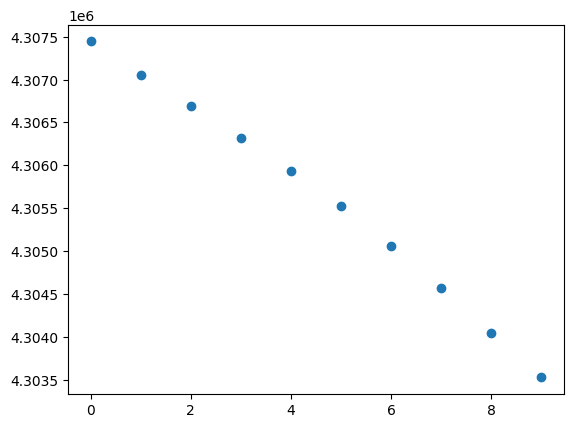

In [240]:
import matplotlib.pyplot as plt
plt.scatter(range(len(losses)), losses)